# Eric's Thesis Project

In [81]:
import pandas as pd
import numpy as np
import sys, os
import pickle, sqlite3
import datetime
import math, random
from scipy import stats
import scipy

import findata_utils as fd

import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def event_timespan(d):
    if d<0:
        return 'pre-event'
    elif d>0:
        return 'post-event'
    else:
        return 'event'
    return 'err'

# Connect to databases
db = 'C:\\Datasets\\thesis.db'
conn = sqlite3.connect(db)
c = conn.cursor()

colors = {}
colors['pre-event'] = 'xkcd:dark salmon'
colors['post-event'] = 'xkcd:denim'

# Load datasets
## Get French 3-Factor Data

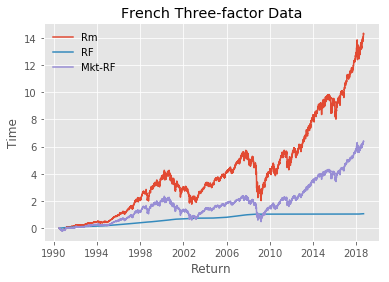

In [2]:
threefactor = fd.get_french('North_America_3_Factors_Daily')
for column in threefactor.columns[1:]:
    threefactor[column] = threefactor[column]*0.01
threefactor['Rm'] = threefactor['Mkt-RF']+threefactor['RF']
threefactor['date'] = threefactor['Date'].apply(lambda Date: datetime.datetime.strptime(str(Date),'%Y%m%d'))
threefactor['CulmRm'] = (threefactor['Rm']+1).cumprod()

# Visualize French data to sanity check
plt.style.use('ggplot')
plt.title('French Three-factor Data')
plt.xlabel('Return')
plt.ylabel('Time')
plt.plot(threefactor['date'],((threefactor['Rm']+1).cumprod()-1))
plt.plot(threefactor['date'],((threefactor['RF']+1).cumprod()-1))
plt.plot(threefactor['date'],((threefactor['Mkt-RF']+1).cumprod()-1))
plt.legend(['Rm','RF','Mkt-RF'], frameon=False, loc='best')
plt.show()

## Pull price data from my local SQLite instance

In [3]:
# Query the database for close price data
px = pd.read_sql('''
    SELECT date,ticker, MAX(c) AS c
    FROM cfmrc
    WHERE ticker IN
        (SELECT ticker FROM indexchanges) 
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

# Query the database for close price data
allpx = pd.read_sql('''
    SELECT date,ticker, MAX(c) AS c
    FROM cfmrc
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

print('Obtained %d close prices' % len(px.index))

rebal_day = pd.read_sql('''
    SELECT s.date, s.ticker, c AS rebalpx, flag
    FROM cfmrc s
    INNER JOIN indexchanges i
    WHERE s.date=i.date 
        AND s.ticker=i.ticker'''
    ,conn)

print('Obtained rebalance day price info for %d securities' % len(rebal_day.index))

Obtained 277212 close prices
Obtained rebalance day price info for 178 securities


# Try to calculate rates of return on adds/deletes

In [4]:
# Merge rebalance data to price data
df = px.merge(rebal_day, on=['ticker'])
df.columns = ['date','ticker','px','rebal','rebalpx','flag']

df['flag'] = df['flag'].apply(lambda flag: 1 if flag==1 else -1)

# Compute price deltas
df['delta'] = (df['px']-df['rebalpx'])*df['flag']
df['return'] = df['delta']/df['rebalpx']

# Parce dates
df['date'] = df['date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))
df['rebal'] = df['rebal'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))

# Days unitl rebal
df['d'] = df['date']-df['rebal']
df['d'] = df['d'].apply(lambda d: d.days)

df = df.merge(threefactor[['Rm','CulmRm','date']], on=['date'])

print(df.head())

        date  ticker     px      rebal  rebalpx  flag  delta    return     d  \
0 2012-09-19  AAR.UN   4.97 2015-03-20     5.01     1  -0.04 -0.007984  -912   
1 2012-09-19    AC.B   1.23 2013-09-20     3.30     1  -2.07 -0.627273  -366   
2 2012-09-19     ACQ  12.30 2014-06-20    85.98     1 -73.68 -0.856943  -639   
3 2012-09-19     ACQ  12.30 2016-03-18    18.00    -1   5.70  0.316667 -1276   
4 2012-09-19      AD  23.64 2013-09-20    35.20     1 -11.56 -0.328409  -366   

       Rm    CulmRm  
0  0.0016  7.142968  
1  0.0016  7.142968  
2  0.0016  7.142968  
3  0.0016  7.142968  
4  0.0016  7.142968  


In [5]:
daily_returns = pd.pivot_table(df, index=['d'], columns=['ticker'], values=['px']).pct_change()+1
daily_returns.columns = daily_returns.columns.get_level_values(1)
daily_returns.reset_index(inplace=True)
#daily_returns
daily_returns = daily_returns.melt()
days = daily_returns[daily_returns['ticker']=='d']['value'].values
daily_returns = daily_returns[daily_returns['ticker']!='d']
daily_returns['d'] = 0
daily_returns.reset_index(inplace=True)
daily_returns['d'] = daily_returns['index'].apply(lambda index: days[index%len(days)])
daily_returns.drop_duplicates(inplace=True)
daily_returns.drop('index',axis=1, inplace=True)
daily_returns.dropna(inplace=True)
daily_returns = daily_returns.reindex()

daily_returns['timespan'] = daily_returns['d'].apply(lambda d: event_timespan(d))

mean = daily_returns.groupby(by=['ticker','timespan'])['value'].mean().reset_index()
sd = daily_returns.groupby(by=['ticker','timespan'])['value'].std().reset_index()
daily_returns = mean.merge(sd, on=['ticker','timespan'],suffixes=('_mean','_sd'))
daily_returns = daily_returns[(daily_returns['timespan'] == 'post-event') | (daily_returns['timespan'] == 'pre-event')]

print(daily_returns.dropna().groupby(by='timespan').mean().reset_index())

     timespan  value_mean  value_sd
0  post-event    1.001961  0.060059
1   pre-event    1.001171  0.041705


## Calculate market return, benchmarked to the add/del date

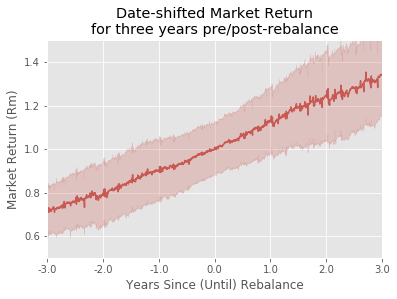

In [6]:
adjustments = df[df['d']==0][['ticker','CulmRm']]
adjustments.columns = ['ticker','CulmRmAtT0']
df = df.merge(adjustments, on=['ticker'])
df['IndRm'] = (df['CulmRm']/df['CulmRmAtT0'])-1

m = df[['d','IndRm']].groupby(by='d').mean().reset_index()
s = df[['d','IndRm']].groupby(by='d').std().reset_index()
Rm = m.merge(s, on='d', suffixes=('Avg','SD'))

# Visualize market returns
plt.style.use('ggplot')
plt.plot(Rm['d'],Rm['IndRmAvg']+1, color='#c85a53')
plt.fill_between(Rm['d'], Rm['IndRmAvg']-Rm['IndRmSD']+1, Rm['IndRmAvg']+Rm['IndRmSD']+1, color="#c85a53", alpha=0.25)
plt.xlim(-1095,1095)
plt.ylim(0.5,1.5)
xrange = 1095
plt.xticks(np.linspace(-xrange,xrange,1+2*math.floor(xrange/(365))),np.linspace((-xrange/365),(xrange/365),1+(2*math.floor(xrange/365))))
plt.title('Date-shifted Market Return\nfor three years pre/post-rebalance')
plt.xlabel('Years Since (Until) Rebalance')
plt.ylabel('Market Return (Rm)')
plt.show()

## Calculate the risk per stock

In [7]:
beta = df[['date','d','ticker','return','Rm']].drop_duplicates()

risk = []
for ticker in beta['ticker'].unique():
    # Calculate the risk per security
    sample = beta[beta['ticker']==ticker][['d','Rm','return']]
    
    for timespan in ['lifetime','pre-event','post-event']:
        # Compute for whether or not this is before or after the rebalance event
        security_risk = pd.Series(name=ticker)
        security_risk['timespan'] = timespan
        
        if timespan=='pre-event':
            subsample=sample[sample['d']<0]
        elif timespan=='post-event':
            subsample=sample[sample['d']>0]
        else:
            subsample=sample

        slope, intercept, r_value, p_value, std_err = stats.linregress(subsample['Rm'], subsample['return'])

        security_risk['intercept'] = intercept
        security_risk['beta'] = slope
        security_risk['idio'] = r_value**2

        risk.append(pd.DataFrame(security_risk).T.reset_index())
    
risk = pd.concat(risk)

print(risk.head(5))

df['timespan'] = df['d'].apply(lambda d: event_timespan(d))

risk = risk.merge(daily_returns, left_on=['index','timespan'], right_on=['ticker','timespan'], suffixes=('','_return'))
risk.drop('ticker',axis=1,inplace=True)

risk.columns = ['ticker','timespan','intercept','beta','idio','return','sd']

    index    timespan   intercept      beta         idio
0  AAR.UN    lifetime   0.0585716  0.298187  0.000131868
0  AAR.UN   pre-event  -0.0574595  0.326005    0.0018211
0  AAR.UN  post-event    0.149792  0.624765  0.000500058
0    AC.B    lifetime -0.00217064  0.557193  5.53243e-05
0    AC.B   pre-event   -0.389747  0.721314    0.0011174


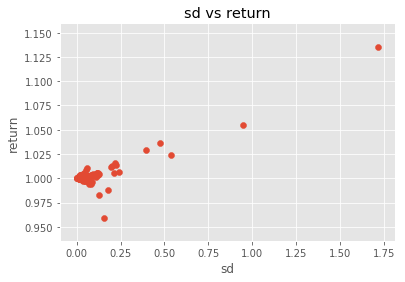

In [8]:
plt.style.use('ggplot')
axis = ['sd','return']

#slope, intercept, r_value, p_value, std_err = stats.linregress(risk[axis[0]], risk[axis[1]])

#def interpolate(slope, intercept, x):
#    return intercept + x*slope

#X_inter = np.linspace(risk[axis[0]].min(), risk[axis[0]].max())
#Y_inter = [interpolate(slope, intercept, x) for x in X_inter]

plt.scatter(risk[axis[0]],risk[axis[1]])
plt.xlabel(axis[0])
plt.ylabel(axis[1])
plt.title('%s vs %s' % (axis[0],axis[1]))
plt.show()

# Compare returns on adds/dels to the market

## Investigate stock-specific abnormal returns

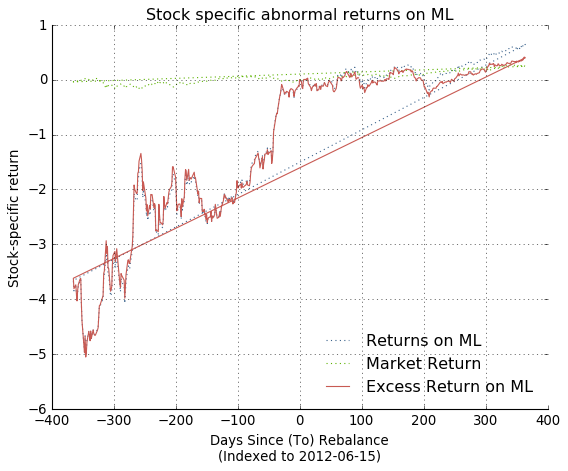

In [9]:
ticker = random.choice(df['ticker'].unique())
stock_df = df[(df['ticker']==ticker) & (abs(df['d'])<=365)]

plt.style.use('classic')

fig = plt.figure()
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.plot(stock_df['d'],stock_df['return'], color='xkcd:denim',linestyle=':')
ax.plot(stock_df['d'],stock_df['IndRm'], color='xkcd:kermit green',linestyle=':')
ax.plot(stock_df['d'],stock_df['return']-stock_df['IndRm'], color='xkcd:dark salmon',linestyle='-')

ax.legend(['Returns on %s'%ticker,'Market Return','Excess Return on %s'%ticker], frameon=False, loc='best')

plt.ylabel('Stock-specific return')
plt.xlabel('Days Since (To) Rebalance\n(Indexed to %s)' % df[df['ticker']==ticker]['rebal'].min().strftime('%Y-%m-%d'))
plt.title('Stock specific abnormal returns on %s'%ticker)

#plt.xlim(-91,91)
#plt.ylim(-1,1)
plt.show()

plt.show()

## Investigate portfolio-wide abnormal returns

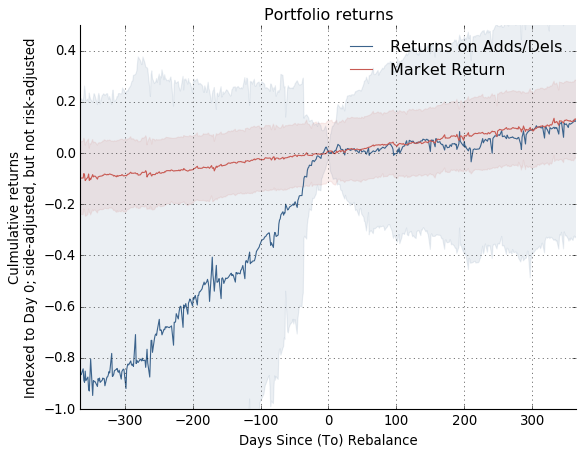

In [10]:
plt.style.use('classic')
daily = df[['ticker','d','return']].drop_duplicates()
daily = pd.pivot_table(daily, index='d',columns='ticker',values='return', aggfunc=np.max).reset_index()

daily['avg'] = daily.drop('d',axis=1).mean(axis=1)
daily['std'] = daily.drop('d',axis=1).std(axis=1)

fig = plt.figure()
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.plot(daily['d'],daily['avg'], color='#3b638c')
ax.plot(daily['d'],Rm['IndRmAvg'], color='#c85a53')

ax.fill_between(daily['d'], daily['avg']-daily['std'], daily['avg']+daily['std'], color="#3b638c", alpha=0.1)
ax.fill_between(daily['d'], Rm['IndRmAvg']-Rm['IndRmSD'], Rm['IndRmAvg']+Rm['IndRmSD'], color="#c85a53", alpha=0.1)

ax.legend(['Returns on Adds/Dels','Market Return'], frameon=False, loc='best')

plt.title('Portfolio returns')
plt.ylabel('Culmulative returns\nIndexed to Day 0; side-adjusted, but not risk-adjusted')
plt.xlabel('Days Since (To) Rebalance')
plt.xlim(-365,365)
plt.ylim(-1,.5)
plt.show()

#print(daily[(daily['d']>-5) & (daily['d']<8)])

## Do adds/dels out-perform the market?

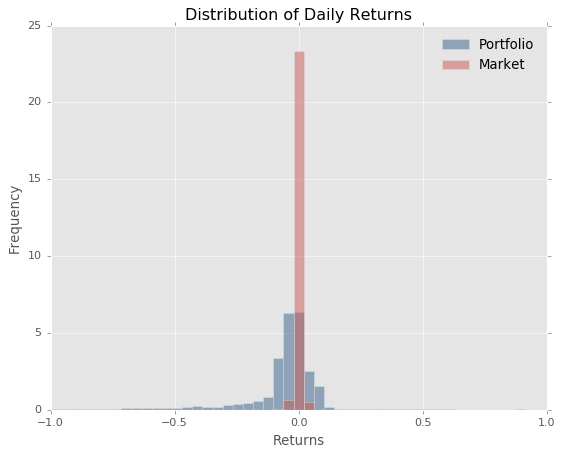

In [11]:
all_returns = []
for i,j in daily.iterrows():
    all_returns.extend(j.drop(['d','avg','std']).dropna().values)
    
# Renormalize returns, because something is not right
all_returns = [r/10 for r in all_returns]

mkt_returns = list(threefactor[(threefactor['date']>df['date'].min())&(threefactor['date']<df['date'].max())]['Rm'].values)

plt.style.use('ggplot')
plt.hist(all_returns, density=True, range=[-1,1], alpha=0.5, bins=np.linspace(-1,1,50), color='#3b638c')
plt.hist(mkt_returns, density=True, range=[-1,1], alpha=0.5, bins=np.linspace(-1,1,50), color='#c85a53')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Returns')
plt.legend(['Portfolio','Market'], frameon=False, loc='best')
plt.show()

# Risk Adjust the Returns

## Do post-inclusion securities have a better Sharpe ratio?

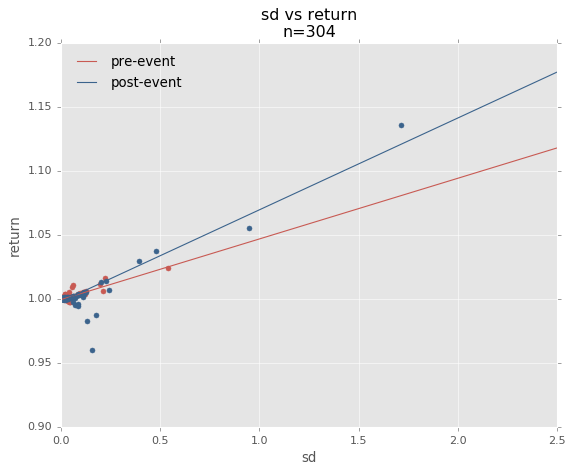

In [12]:
x,y = 'sd','return'
xlim = [0,2.5]

for timespan in risk['timespan'].unique():
    subsample = risk[risk['timespan']==timespan].dropna()
    plt.scatter(subsample[x], subsample[y], color=colors[timespan])#, alpha=0.5)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(subsample[x], subsample[y])

    X = np.linspace(xlim[0], xlim[1], 20)
    Y = X*slope + intercept
    plt.plot(X,Y, color=colors[timespan], alpha=1)
    #plt.fill_between(X, Y-std_err,Y+std_err, color=colors[timespan], alpha=0.1)
    
plt.xlim(xlim)
plt.xlabel(x)
plt.ylabel(y)
plt.title('%s vs %s\nn=%d' % (x, y, len(risk.index)))
plt.legend(risk['timespan'].unique(), frameon=False, loc='best')
plt.show()

# Clean up the environment

In [ ]:
c.close()

# Create a new analytic table

In [73]:
r_value

0.22642397807457748

In [89]:
compute_return_on = 'c'

curvefits = []

for ticker in px.ticker.unique():
    r = pd.DataFrame(px[px.ticker==ticker][compute_return_on].pct_change()+1).fillna(1)
    r['date'] = px['date'].apply(lambda date: np.datetime64(date))
    r = r.merge(threefactor[['Rm','date']], on=['date'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(r['Rm']+1, r[compute_return_on])
    
    alpha = r[compute_return_on] - (r['Rm']+1)
    
    curvefit = pd.Series(name=ticker)
    
    # Summary statistics on the curve fit
    curvefit['fit_beta'] = slope
    curvefit['fit_intercept'] = intercept
    curvefit['fit_idiosyncratic'] = r_value**2
    curvefit['fit_p'] = p_value
    curvefit['fit_stderr'] = std_err
    
    # Summary statistics on return
    curvefit['return_sd'] = r[compute_return_on].std()
    curvefit['return_mean'] = r[compute_return_on].mean()
    curvefit['return_gmean'] = scipy.stats.mstats.gmean(r[compute_return_on])
    
    # Summary statistics on alpha
    curvefit['alpha_sd'] = alpha.std()
    curvefit['alpha_mean'] = alpha.mean()
    curvefit['alpha_gmean'] = scipy.stats.mstats.gmean(alpha+1)-1
    
    curvefits.append(pd.DataFrame(curvefit).T)

curvefits = pd.concat(curvefits)
curvefits.dropna(inplace=True)
cf = curvefits

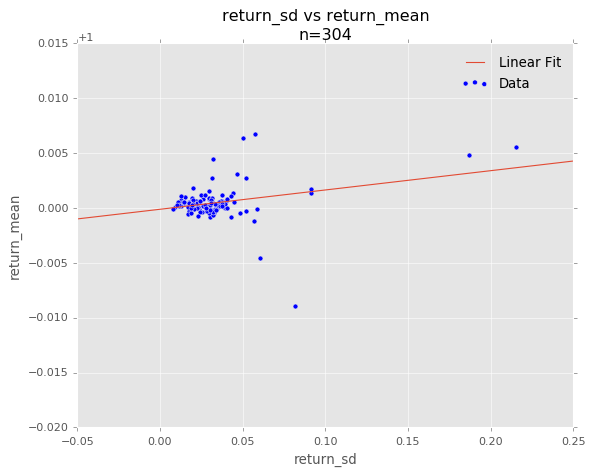

In [104]:
x,y = 'return_sd','return_mean'

plt.scatter(cf[x], cf[y])#, color=colors[timespan])#, alpha=0.5)
xlim = plt.xlim()
    
slope, intercept, r_value, p_value, std_err = stats.linregress(cf[x], cf[y])

X = np.linspace(xlim[0], xlim[1], 20)
Y = X*slope + intercept
plt.plot(X,Y)
plt.xlim(xlim)
    
plt.xlabel(x)
plt.ylabel(y)
plt.title('%s vs %s\nn=%d' % (x, y, len(risk.index)))
plt.legend(['Linear Fit','Data'], frameon=False, loc='best')
plt.show()